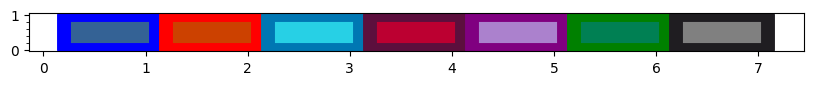

In [1]:
import json

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.patches as ptchs
import matplotlib.pyplot as plt
import matplotlib.text as mtext
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import scipy.integrate
import scipy.optimize
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter
from pandas.core.base import PandasObject
from sklearn.linear_model import Ridge

system = "das6"
vd_input_folder = f"{system}-cpu/"
mb_input_folder = f"../microbenchmarks/{system}/"
output_folder = f"../../images/defense"

%run ../notebook_setup.ipynb

# Model

In [ ]:
%%capture
# %run ../cpu-sequential/validation.ipynb
%run ../gpu-synchronous/validation.ipynb

In [3]:
# maxsmem = 49152 #
# l2_size = 4194304 # 48 KB
# l2_persistent_size = 3145728 # 48 KB
gpu_maxsmem, gpu_l2_size, gpu_l2_persistent_size

(49152, 4194304, 3145728)

In [4]:
# norm = unit_to_unit_factor("us", "ns")
# T_globmem = 700 * norm
# T_l2 = 100 * norm
# T_l1 = 0.1 * norm
# p_fb = 262144
# tau_1 = 16e3
# tau_2 =  l2_size/8
T_gpu_l1, T_gpu_l2, T_gpu_globmem, "      ", tau_1, tau_2, "      ", p_fb

NameError: name 'T_gpu_l1' is not defined

In [ ]:
def T_gpu_binsearch(bulksize, subsize):
    try:
        T = np.repeat(T_gpu_globmem, len(subsize)).astype(np.float64)
        T[subsize < tau_2] = T_gpu_l2 * (bulksize * p_fb)
        T[subsize < tau_1] = T_gpu_l1 * (bulksize * p_fb)
        return T * (bulksize * p_fb)
    except:
        if subsize < tau_1:
            return T_gpu_l1 * (bulksize * p_fb)
        elif subsize < tau_2:
            return T_gpu_l2 * (bulksize * p_fb)
        else:
            return T_gpu_globmem * (bulksize * p_fb)

In [ ]:
# T_globatomic_popt = [1.66528941e+00, 1.94094708e+03]
# T_lclatomic_popt = [8.71109531e-01, 1.52247128e+04]

In [ ]:
def T_atomic(nthreads, a, b):
    return a * nthreads + b


def T_gpu_addbincontent(global_kernel, bulksize, subsize):
    global_kernel = np.array(global_kernel)
    lcl_kernel = np.invert(global_kernel)

    try:
        T = np.zeros(len(global_kernel))
        T[global_kernel] = T_atomic(
            bulksize / subsize[global_kernel], *T_globatomic_popt
        )
        T[lcl_kernel] = T_atomic(bulksize / subsize[lcl_kernel], *T_lclatomic_popt)
    except:
        if global_kernel:
            T = T_atomic(bulksize / subsize, *T_globatomic_popt)

        else:
            T = T_atomic(bulksize / subsize, *T_lclatomic_popt)

    return T

In [ ]:
# Tusb_popt = [2.27171755e-02, 2.82317569e+03]
Tusb_popt

In [ ]:
def T_gpu_usb(bulksize, a, b):
    return a * bulksize + b

In [ ]:
# ibw_smallpinned_popt = [8.46108875e-02, 9.81633439e-01, 8.36754834e+03]
# ibw_smallpaged_popt  = [5.21776783e-01, 8.74527915e-01, 9.52116071e+03]
ibw_smallpinned_popt, ibw_smallpaged_popt

In [ ]:
# def ibw_small(bytes, a, b, c, d, e, f):
#     return (a*pow(bytes, 0)
#             + b *pow(bytes, 1)
#             + c *pow(bytes, 2)
#             + d *pow(bytes, 3)
#             + e *pow(bytes, 4)
#             + f *pow(bytes, 5)
#             + g *pow(bytes, 6)
#             + h *pow(bytes, 7)
#             + i *pow(bytes, 8)
# ).clip(0)

# def ibw_small(bytes, a,b,c):
#     return a*pow(bytes, b) + c

In [ ]:
# tau_4 = 33554432
gpu_bw_threshold

In [ ]:
# maxibw_htod_pinned = 0.06183371910866478
# maxibw_htod_paged  = 0.06364053827440774
gpu_maxibw_htod_pinned, gpu_maxibw_htod_paged

In [ ]:
def T_memcpy(bytes, pinned):
    maxibw = gpu_maxibw_htod_pinned if pinned else gpu_maxibw_htod_paged
    popt = ibw_smallpinned_popt if pinned else ibw_smallpaged_popt

    try:
        T = np.zeros(len(bytes)).astype(np.float64)
        T[bytes < gpu_bw_threshold] = ibw_small(bytes[bytes < gpu_bw_threshold], *popt)
        T[bytes >= gpu_bw_threshold] = maxibw * bytes[bytes >= gpu_bw_threshold]
    except:
        if bytes < gpu_bw_threshold:
            T = ibw_small(bytes, *popt)
        else:
            T = maxibw * bytes
    return np.clip(T, 0, np.inf)

# Comparison

In [ ]:
save = True; figname = f"{output_folder}/overlap_prediction.pdf" # fmt: skip
print(figname)
norm = unit_to_unit_factor("ns", "s")
selected_blocksize = 256

fig = plt.figure(figsize=(8, 3))
ax = plt.subplot(111)

bulksize = np.linspace(0, 256 * unit_to_unit_factor("mb", "b", bytes=True) / 8)
nbins = np.linspace(10, 2 * gpu_l2_size / 8)

### Global

cmap = mpl.colors.LinearSegmentedColormap.from_list(
    "", ["#E2E9F0", colors[0]], N=len(nbins)
)
cmapcolors = plt.cycler("color", cmap(np.linspace(0, 1, len(nbins)))).by_key()["color"]
for nbi, nb in enumerate(nbins):
    blocks = (bulksize + (selected_blocksize * 2 - 1)) / (selected_blocksize * 2)
    T_usb = 4 * (
        T_gpu_usb(bulksize, *Tusb_popt)  # main reduction
        + T_gpu_usb(blocks, *Tusb_popt)
    )  # final reduction
    T_abc = T_gpu_addbincontent(True, bulksize, nb)
    T_fb = T_gpu_binsearch(nb, bulksize)
    pred = (T_usb + T_abc + T_fb) * norm 
    plt.plot(bulksize, pred, color=cmapcolors[nbi])

normali = mpl.colors.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=normali)
sm.set_array([])
start_of_clb_cell = np.cumsum(np.repeat(1 / len(nbins), len(nbins)))
middle_of_clb_cell = start_of_clb_cell - (1 / (2 * len(nbins)))
div = min(len(nbins), 10)
idx = np.linspace(0, len(start_of_clb_cell) - 1, div, dtype=int)
clb = plt.colorbar(
    sm,
    ticks=middle_of_clb_cell[idx],
    format=ticker.FuncFormatter(
        lambda x, pos, nbins=nbins, idx=idx: f"{human_readable(nbins[idx[pos]])}"
    ),
    ax=ax,
    aspect=11,
)
clb.ax.set_xlabel(
    (f'Version\nGlobal'),
    # fontsize=,
)
clb.ax.set_ylabel(
    (f'{" "*0}Number of bins'),
    fontsize=12,
)
### LoCAL

cmap = mpl.colors.LinearSegmentedColormap.from_list(
    "", ["#FDEBDB", colors[1]], N=len(nbins)
)
cmapcolors = plt.cycler("color", cmap(np.linspace(0, 1, len(nbins)))).by_key()["color"]
nbins = np.linspace(10, 4096)
for nbi, nb in enumerate(nbins):
    blocks = (bulksize + (selected_blocksize * 2 - 1)) / (selected_blocksize * 2)
    T_usb = 4 * (
        T_gpu_usb(bulksize, *Tusb_popt)  # main reduction
        + T_gpu_usb(blocks, *Tusb_popt)
    )  # final reduction
    T_abc = T_gpu_addbincontent(False, bulksize, nb)
    T_fb = T_gpu_binsearch(nb, bulksize)
    pred = (T_usb + T_abc + T_fb) * norm
    plt.plot(bulksize, pred, color=cmapcolors[nbi],)

normali = mpl.colors.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=normali)
sm.set_array([])
start_of_clb_cell = np.cumsum(np.repeat(1 / len(nbins), len(nbins)))
middle_of_clb_cell = start_of_clb_cell - (1 / (2 * len(nbins)))
div = min(len(nbins), 10)
idx = np.linspace(0, len(start_of_clb_cell) - 1, div, dtype=int)
clb = plt.colorbar(
    sm,
    ticks=middle_of_clb_cell[idx],
    format=ticker.FuncFormatter(
        lambda x, pos, nbins=nbins, idx=idx: f"{human_readable(nbins[idx[pos]])}"
    ),
    ax=ax,
    aspect=11,
)
clb.ax.set_xlabel(
    (f'Version\nLocal'),    # fontsize=,
)

## Memcpy
pinned = True
# plt.plot(bulksize, 2 * T_memcpy(bulksize * 8, pinned) * norm, label="Memcpy HToD")

norm = unit_to_unit_factor(mcpybm_mean["time_unit"].values[0], unit) / mcpybm_mean["repetitions"].values[0]
arg = (mcpybm_mean["pinned"] == pinned)
# plt.plot(mcpybm_mean.loc[arg]["nbytes"], mcpybm_mean.loc[arg]["nbytes"]/mcpybm_mean.loc[arg]["real_time"] * norm, "o-")
plt.errorbar(
    mcpybm_mean.loc[arg]["nbytes"]/8,
    mcpybm_mean.loc[arg]["real_time"] * norm,
    yerr=mcpybm_std.loc[arg]["real_time"] * norm,
     label="Memcpy HToD",
    # color=colors[di], marker="s" if pi else "^", markerfacecolor="none",
    # color=colors[pinned],
    # **bm_style,
    color=uvablack, ls=":"
)

plt.ylabel("Runtime (s)")
# plt.xscale("log")

ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(
        lambda x, _: f"{human_readable(int(x))}\n{human_readable(int(x)*8, bytes=True)}"
    )
)
# plt.xscale("log")
plt.xlabel("Bulk size\nBytes")
plt.legend()
if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")

In [ ]:
human_readable(l2_size, bytes=True)